In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


# University of Strathclyde - MSc Artificial Intelligence and Applications

# CS982 - Big Data Technologies

File Created first created 16th October 2019 by Barry Smart.

# Stage 9 - Application of Supervised Methods
The purpose of this notebook is to run a range of supervised models on the data.
The objective is to determine how successfully clustering models can be used to label given the *ground truth* of *Income GrouP*.



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns


## Stage 9.1 - Read in the Data and Prepare it for Analysis
 Read in the file that was generated from the warngling and cleaning scripts.

In [2]:
data_path = str(os.getcwd()) + "\\assignment1\\"
interpolated_data_set = pd.read_pickle(data_path + "interpolated_data_set.pkl")


 Adding "Log GDP" in order to generate more meaningful analysis.

In [3]:
interpolated_data_set["Log GDP per Capita"] = np.log10(interpolated_data_set["GDP per capita (current US$)"])


## Stage 9.2 - Grab Data For 1990
 I will train the model using data for 1990 only.  So grab that year data ussing the xs function.

In [4]:
# Helper function to extract cross section of data based on year - I've chosen here to grab data for a single year.
def grab_year(data_frame, year):
    single_year_data_frame = data_frame.xs(year, level="Year", drop_level=False)
    return single_year_data_frame


single_year_data_frame_1990 = grab_year(interpolated_data_set, 1990)
single_year_data_frame_1990


Upper middle income Equatorial Guinea    1990s  1990                                48.775000   
                                        Gabon                1990s  1990                                60.965000   
                                        Mauritius            1990s  1990                                69.404878   
                                        Namibia              1990s  1990                                61.608000   
                                        South Africa         1990s  1990                                63.307000   

Series Name                                                               Market capitalization of listed domestic companies (current US$)  \
Region              Income Group        Country              Decade Year                                                                     
East Asia & Pacific High income         Australia            1990s  1990                                       1.079360e+11                  
                                        Brunei               1990s  1990                                                NaN                  
                                        French Polynesia     1990s  1990                                                NaN                  
                                        Guam                 1990s  1990                                                NaN                  
                                        Hong Kong SAR, China 1990s  1990                                       8.338587e+10                  
...                                                                                                                     ...                  
Sub-Saharan Africa  Upper middle income Equatorial Guinea    1990s  1990                                                NaN                  
                                        Gabon                1990s  1990                                                NaN                  
                                        Mauritius            1990s  1990                                                NaN                  
                                        Namibia              1990s  1990                                                NaN                  
                                        South Africa         1990s  1990                                       1.368687e+11                  

Series Name                                                               Merchandise exports (current US$)  \
Region              Income Group        Country              Decade Year                                      
East Asia & Pacific High income         Australia            1990s  1990                       3.975200e+10   
                                        Brunei               1990s  1990                       2.213000e+09   
                                        French Polynesia     1990s  1990                       1.110000e+08   
                                        Guam                 1990s  1990                       8.200000e+07   
                                        Hong Kong SAR, China 1990s  1990                       8.239000e+10   
...                                                                                                     ...   
Sub-Saharan Africa  Upper middle income Equatorial Guinea    1990s  1990                       6.200000e+07   
                                        Gabon                1990s  1990                       2.204000e+09   
                                        Mauritius            1990s  1990                       1.194000e+09   
                                        Namibia              1990s  1990                       1.085000e+09   
                                        South Africa         1990s  1990                       2.354900e+10   

Series Name                                                               ...  \
Region              Income Group        Country              D

## Stage 6.2 - Create Training and Test Data Sets
 Now create the training and test data set, using the standard convention:
 - X - is the matrix containing the set of N feature / variable vectors;
 - Y - is the set of N target variables associated with X.
 - each will be split into a test and training data set, so 4 data sets in total.

In [5]:
# Set target column:
linear_regression_target_column = 'Life expectancy at birth, total (years)'

# Select the feature columns:
linear_regression_feature_columns = [ \
    #'Account ownership at a financial institution or with a mobile-money-service provider, young adults (% of population ages 15-24)',\
    #'Electric power consumption (kWh per capita)',\
    #'Energy use (kg of oil equivalent per capita)',\
    #'Fossil fuel energy consumption (% of total)',\
    'Immunization, DPT (% of children ages 12-23 months)',\
    #'Inflation, consumer prices (annual %)',\
    #'Market capitalization of listed domestic companies (current US$)',\
    #'Merchandise exports (current US$)',\
    #'Mobile cellular subscriptions (per 100 people)',\
    #'Mortality caused by road traffic injury (per 100,000 people)',\
    #'Mortality rate attributed to household and ambient air pollution, age-standardized (per 100,000 population)',\
    #'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)',\
    'Mortality rate, infant (per 1,000 live births)',\
    #'Population density (people per sq. km of land area)',\
    #'Population growth (annual %)', 'Population, total',\
    #'Power outages in firms in a typical month (number)',\
    'Renewable energy consumption (% of total final energy consumption)',\
    #'Suicide mortality rate (per 100,000 population)',\
    #'Tax revenue (% of GDP)', 'Urban population growth (annual %)',\
    'Log GDP per Capita']


In [6]:
# Helper function to extract target and feature dataframes
def get_target_and_features(data_frame, target_column, feature_column_list):
    # Build a list of all columns
    all_columns = feature_column_list + [target_column]
    # Grab only those columns from a "flattened" dataset
    data_frame = data_frame.reset_index()
    data_frame = data_frame[all_columns]
    data_frame = data_frame.dropna()
    target_dataframe = data_frame[target_column].reset_index(drop=True)
    features_dataframe = data_frame[feature_column_list].reset_index(drop=True)
    return target_dataframe, features_dataframe


In [7]:
# Extract the target and feature dataframes from the source data using the helper function:
linear_regression_target_dataframe, linear_regression_features_dataframe = get_target_and_features(single_year_data_frame_1990, linear_regression_target_column, linear_regression_feature_columns)


In [8]:
linear_regression_target_dataframe


0      76.994634
1      70.185000
2      78.836829
3      71.597561
4      75.378049
         ...    
143    59.191000
144    48.775000
145    60.965000
146    69.404878
147    63.307000
Name: Life expectancy at birth, total (years), Length: 148, dtype: float64

In [9]:
linear_regression_features_dataframe


Series Name,"Immunization, DPT (% of children ages 12-23 months)","Mortality rate, infant (per 1,000 live births)",Renewable energy consumption (% of total final energy consumption),Log GDP per Capita
0,95.0,7.6,8.009577,4.260337
1,93.0,10.4,0.671759,4.133779
2,90.0,4.6,4.550664,4.404138
3,74.0,13.3,1.631947,3.814001
4,90.0,9.1,30.030593,4.135547
...,...,...,...,...
143,92.0,39.4,47.584638,3.469208
144,77.0,121.4,84.710860,2.427272
145,78.0,60.2,78.280665,3.797195
146,85.0,19.9,47.067827,3.399012


In [10]:
scaler = StandardScaler()
scaler.fit_transform(linear_regression_features_dataframe, linear_regression_target_dataframe)


array([[ 8.70474505e-01, -1.06714569e+00, -9.23875905e-01,
         1.49055620e+00],
       [ 7.68025020e-01, -9.95730358e-01, -1.14305575e+00,
         1.30097102e+00],
       [ 6.14350794e-01, -1.14366212e+00, -1.02719328e+00,
         1.70597137e+00],
       [-2.05245082e-01, -9.21764476e-01, -1.11437505e+00,
         8.21941188e-01],
       [ 6.14350794e-01, -1.02888748e+00, -2.66110486e-01,
         1.30361907e+00],
       [ 3.58227082e-01, -1.10540391e+00, -1.15730147e+00,
         1.21164464e+00],
       [-9.22391473e-01,  3.17801685e-01,  5.87180957e-01,
        -7.46158196e-01],
       [ 9.72923989e-01,  5.01441116e-01, -1.00717215e+00,
        -7.86550690e-01],
       [-3.07383065e+00,  1.42728992e+00,  1.47872461e+00,
        -1.43399824e+00],
       [ 3.07002340e-01,  7.00383833e-01, -1.10658864e+00,
        -2.93940517e-01],
       [-5.12593535e-01,  3.66262090e-01,  9.78562593e-01,
        -6.31775953e-01],
       [ 5.11901309e-01, -2.40768252e-01,  3.58647475e-01,
      

In [11]:
# Split the data ready for training and testing the model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(linear_regression_features_dataframe, linear_regression_target_dataframe, test_size=0.20)


## Stage 6.3 - Train Linear Regression Model
 Linear regression models are popular because they can be fit very quickly and are very interpretable.
 Here I will apply linear regression to build a predictive model for Life Expectancy based on the 4 variables that strong correlatons with it.

 Train the model
linear_regression_model = LinearRegression(normalize=True)

In [12]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
print("Intercept: ", linear_regression_model.intercept_)


Intercept:  77.04436356609096


In [14]:
pd.DataFrame(list(zip(linear_regression_features_dataframe.columns, linear_regression_model.coef_)), columns = ['Features', 'Coefficients'])


,Features,Coefficients
0,"Immunization, DPT (% of children ages 12-23 mo...",-0.040762
1,"Mortality rate, infant (per 1,000 live births)",-0.212237
2,Renewable energy consumption (% of total final...,-0.038916
3,Log GDP per Capita,0.886235


## Stage 6.4 - Test The Model
 Now test the model and determine how well it performs:


In [15]:
linear_regression_prediction = linear_regression_model.predict(X_test)
print(metrics.mean_squared_error(Y_test, linear_regression_prediction))


7.696094062633113


In [16]:
linear_regression_model.score(X_test, Y_test)


0.9042920335953176

## Stage 6.5 - Apply The Model to Future Years
 Loop through future years, applying the model and comparing predicted Life Expectancy with actual, computing Mean Squared Error:


In [17]:
# Now apply the trained model to future years to see how it performs:
list_of_results = []
detailed_results = pd.DataFrame()
for year in range(1990, 2019):
    single_year_data_frame = grab_year(interpolated_data_set, year)
    target_dataframe, features_dataframe = get_target_and_features(single_year_data_frame, linear_regression_target_column, linear_regression_feature_columns)
    #print(features_dataframe.shape)
    predict = linear_regression_model.predict(features_dataframe)
    mean_squared_error = metrics.mean_squared_error(target_dataframe, predict)
    result = { "Year" : year, "Mean Squared Error" : mean_squared_error, "Average Value" : target_dataframe.mean(), "Average Prediction" : predict.mean()}
    detailed_result_element = pd.DataFrame(predict)
    detailed_result_element.rename(columns={0 : "Prediction"}, inplace=True)
    detailed_result_element["Year"] = year
    detailed_result_element["Target"] = target_dataframe
    list_of_results = list_of_results + [result]
    detailed_results = detailed_results.append(detailed_result_element)
results_dataframe = pd.DataFrame(list_of_results)
results_dataframe


,Year,Mean Squared Error,Average Value,Average Prediction
0,1990,9.197825,64.664428,64.750136
1,1991,10.285826,64.878197,65.097995
2,1992,11.112737,65.229983,65.447581
3,1993,11.394742,65.320196,65.631215
4,1994,11.016166,65.558935,65.855568
5,1995,10.680787,65.746498,66.209902
6,1996,10.578439,65.972387,66.454331
7,1997,10.988160,66.182631,66.688177
8,1998,11.588877,66.383110,66.895821
9,1999,12.746973,66.441225,66.999730


In [18]:
detailed_results


,Prediction,Year,Target
0,75.022934,1990,76.994634
1,74.683593,1990,70.185000
2,76.125504,1990,78.836829
3,74.521818,1990,71.597561
4,73.940821,1990,75.378049
...,...,...,...
181,65.986417,2018,58.061000
182,67.519930,2018,65.839000
183,73.344925,2018,74.514634
184,69.575531,2018,63.021000


## Stage 6.6 - Visualise the Results
 Visualise the results:


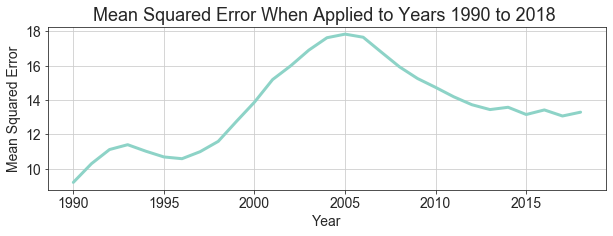

In [19]:
sns.set_style("ticks", {'axes.grid': True, 'grid.color': '.8', 'grid.linestyle': '-', })
plt.rcParams.update({'axes.titlesize' : 16, 'lines.linewidth' : 3,\
    'axes.labelsize' : 14, 'xtick.labelsize' : 14, 'ytick.labelsize' : 14})
f, ax = plt.subplots(figsize=(10, 3))
plt.title("Mean Squared Error When Applied to Years 1990 to 2018 ", fontdict = {"fontsize" : 18})
sns.lineplot(x="Year", y="Mean Squared Error",\
    linewidth=3,\
    data=results_dataframe, ax=ax)



In [20]:
# Melt data into the desired format:
reshaped_detailed_results = pd.melt(detailed_results, id_vars=['Year'])
reshaped_detailed_results.rename(columns={"variable" : "Element", "value" : "Value"}, inplace=True)
reshaped_detailed_results

hue_palette = {"Target" : "black", "Prediction" : "green"}


[None, None]

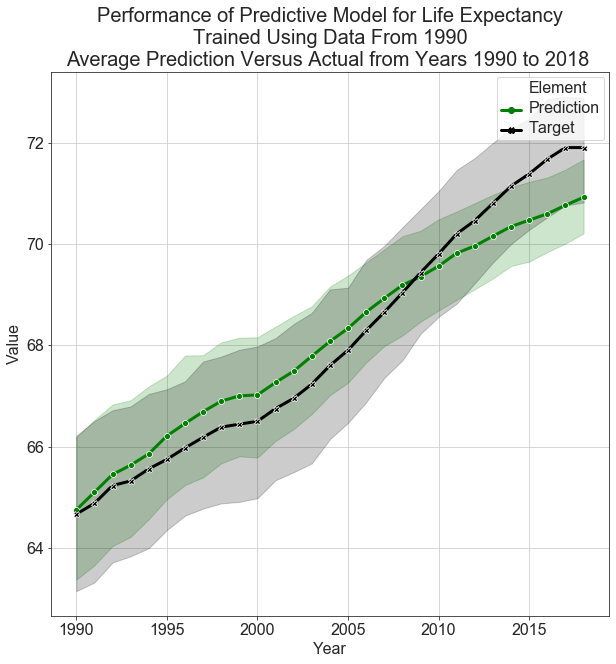

In [21]:
sns.set_style("ticks", {'axes.grid': True, 'grid.color': '.8', 'grid.linestyle': '-', })
plt.rcParams.update({'axes.titlesize' : 18, 'lines.linewidth' : 3,\
    'axes.labelsize' : 16, 'xtick.labelsize' : 16, 'ytick.labelsize' : 16})
f, ax = plt.subplots(figsize=(10, 10))
plt.title("Performance of Predictive Model for Life Expectancy\nTrained Using Data From 1990\nAverage Prediction Versus Actual from Years 1990 to 2018 ", fontdict = {"fontsize" : 20})
sns.lineplot(x="Year", y="Value",\
    linewidth=3,\
    style="Element",\
    hue="Element",\
    palette=hue_palette,\
    markers=True, dashes=False,\
    data=reshaped_detailed_results, ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title


## Stage 6.7 - Naive Bayes


In [22]:
# Set target column:
nb_target_column = 'Income Group'

# Select the feature columns:
nb_feature_columns = [ \
    'Life expectancy at birth, total (years)',\
    'Immunization, DPT (% of children ages 12-23 months)',\
    'Mortality rate, infant (per 1,000 live births)',\
    'Renewable energy consumption (% of total final energy consumption)',\
    'Log GDP per Capita']


In [23]:
# Grab a single year
single_year_data_frame = grab_year(interpolated_data_set, 2000)

# Extract the target and feature dataframes from the source data using the helper function:
nb_target_dataframe, nb_features_dataframe = get_target_and_features(single_year_data_frame_1990, nb_target_column, nb_feature_columns)
nb_target_dataframe


0              High income
1              High income
2              High income
3              High income
4              High income
              ...         
143    Upper middle income
144    Upper middle income
145    Upper middle income
146    Upper middle income
147    Upper middle income
Name: Income Group, Length: 148, dtype: object

In [24]:
# Now assign integer labels for the target classifications
nb_target_dataframe_encoded = LabelEncoder().fit_transform(nb_target_dataframe)
nb_target_dataframe_encoded


array([0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [25]:
nb_features_dataframe


Series Name,"Life expectancy at birth, total (years)","Immunization, DPT (% of children ages 12-23 months)","Mortality rate, infant (per 1,000 live births)",Renewable energy consumption (% of total final energy consumption),Log GDP per Capita
0,76.994634,95.0,7.6,8.009577,4.260337
1,70.185000,93.0,10.4,0.671759,4.133779
2,78.836829,90.0,4.6,4.550664,4.404138
3,71.597561,74.0,13.3,1.631947,3.814001
4,75.378049,90.0,9.1,30.030593,4.135547
...,...,...,...,...,...
143,59.191000,92.0,39.4,47.584638,3.469208
144,48.775000,77.0,121.4,84.710860,2.427272
145,60.965000,78.0,60.2,78.280665,3.797195
146,69.404878,85.0,19.9,47.067827,3.399012


In [26]:
X_nb_train, X_nb_test, Y_nb_train, Y_nb_test = sklearn.model_selection.train_test_split(nb_features_dataframe, nb_target_dataframe_encoded, test_size = 0.25)


In [27]:
naive_bayes_model = GaussianNB()


In [28]:
naive_bayes_model.fit(X_nb_train, Y_nb_train)


GaussianNB(priors=None, var_smoothing=1e-09)

In [29]:
naive_bayes_prediction = naive_bayes_model.predict(X_nb_test)
print("Naive Bayes model accuracy score: ", metrics.accuracy_score(Y_nb_test,naive_bayes_prediction))


Naive Bayes model accuracy score:  0.7297297297297297


In [30]:
print(metrics.classification_report(Y_nb_test, naive_bayes_prediction))


precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.71      0.83      0.77         6
           2       1.00      0.62      0.77         8
           3       0.55      0.67      0.60         9

    accuracy                           0.73        37
   macro avg       0.76      0.73      0.73        37
weighted avg       0.76      0.73      0.73        37



In [31]:
print(metrics.confusion_matrix(Y_nb_test,naive_bayes_prediction))


[[11  0  0  3]
 [ 0  5  0  1]
 [ 0  2  5  1]
 [ 3  0  0  6]]
